In [1]:
import os
import random
from PIL import Image
import argparse

import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
team_id = 15
team_name = "loSSLess"
email_address = "vvb238@nyu.edu"

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, split, transform, limit=0):
        r"""
        Args:
            root: Location of the dataset folder, usually it is /dataset
            split: The split you want to used, it should be one of train, val or unlabeled.
            transform: the transform you want to applied to the images.
        """

        self.split = split
        self.transform = transform

        self.image_dir = os.path.join(root, split)
        label_path = os.path.join(root, f"{split}_label_tensor.pt")

        if limit == 0:
            self.num_images = len(os.listdir(self.image_dir))
        else:
            self.num_images = limit

        if os.path.exists(label_path):
            self.labels = torch.load(label_path)
        else:
            self.labels = -1 * torch.ones(self.num_images, dtype=torch.long)

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        with open(os.path.join(self.image_dir, f"{idx}.png"), 'rb') as f:
            img = Image.open(f).convert('RGB')

        return self.transform(img), self.labels[idx]

In [4]:
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
#     transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

eval_transform = transforms.Compose([
#     transforms.Resize((64,64)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
# trainset = CustomDataset(root='/dataset', split="train", transform=train_transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

In [6]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
  plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0))
  plt.title(title)
  plt.axis('off')

def show_image(img, title=None):
  plt.imshow(img.detach().cpu().permute(1, 2, 0))
  plt.title(title)
  plt.axis('off')

# show_normalized_image(trainset[11][0])

In [7]:
# for i in range(200):
#     if trainset[i][1] == 15:
#         print("found")
#         show_normalized_image(trainset[i][0])
#         plt.show()

In [79]:
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor

class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 64
        self.z_dim = z_dim
        self.conv1 = nn.Conv2d(nc, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlockEnc, 64, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlockEnc, 128, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 256, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 512, num_Blocks[3], stride=2)
        self.linear = nn.Linear(512, 2 * z_dim)

    def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BasicBlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=4)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = torch.sigmoid(self.conv1(x))
        x = x.view(x.size(0), 3, 64, 64)
        return x

class VAE(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x, mean, logvar
    
    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

In [80]:
unlabeled_transform = transforms.Compose([
#     transforms.Resize((64,64)),
    transforms.ToTensor(),
])

unlabeledSet = CustomDataset(root='/dataset', split="train", transform=unlabeled_transform, limit=0)
unlabeledLoader = torch.utils.data.DataLoader(unlabeledSet, batch_size=64, shuffle=True, num_workers=2)

In [81]:
# unlabeledSet[:2560]

Total number of images 25600


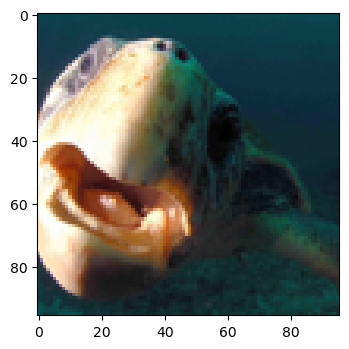

In [82]:
print("Total number of images", len(unlabeledSet))
plt.imshow(unlabeledSet[5][0].permute(1, 2, 0))
plt.show()

In [83]:
vae = VAE(256).cuda()

In [84]:
import torch.optim as optim
optimizer = optim.Adam(vae.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

def loss_func(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [85]:
save_model_location = '/scratch/vvb238/models/'
os.makedirs(save_model_location, exist_ok=True)

In [88]:
print('Start Training')
numOfBatches = len(unlabeledSet)/unlabeledLoader.batch_size

for epoch in range(0, 10):
    print("Epoch Number ", epoch, "\n")
    vae.train()
    l_sum = 0
    for idx, data in tqdm(enumerate(unlabeledLoader), total=int(numOfBatches)):
        # x = torch.sigmoid(x).cuda()
        x, _ = data
        x = x.cuda()
        optimizer.zero_grad()
        recon_x, mu, logvar = vae.forward(x)
        loss = loss_func(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        l_sum += loss
    scheduler.step(l_sum)
#     break
    torch.save(vae.state_dict(), os.path.join(save_model_location, "vaeresnet18.pth"))
    print("Finished Epoch, Loss: ", l_sum / numOfBatches)

    

Start Training
Epoch Number  0 



  0%|          | 0/400 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 64, 3, 3], expected input[64, 128, 24, 24] to have 64 channels, but got 128 channels instead

In [ ]:
# save_model_location = '/scratch/vvb238/models/'
# os.makedirs(save_model_location, exist_ok=True)
# torch.save(vae.state_dict(), os.path.join(save_model_location, "vaeresnet18.pth"))

In [63]:
eval_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

evalset = CustomDataset(root='/dataset', split="val", transform=eval_transform)
evalloader = torch.utils.data.DataLoader(evalset, batch_size=1, shuffle=True, num_workers=2)

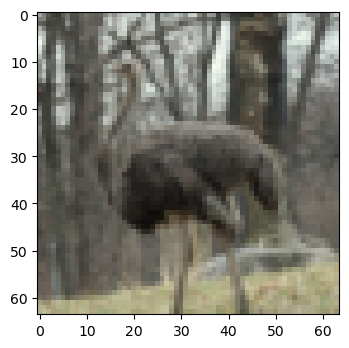

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x15523ff40820>
Traceback (most recent call last):
  File "/ext3/miniconda3/envs/dev/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/ext3/miniconda3/envs/dev/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/ext3/miniconda3/envs/dev/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


torch.Size([3, 64, 64])
<PIL.Image.Image image mode=RGB size=64x64 at 0x15523ECFFF40>


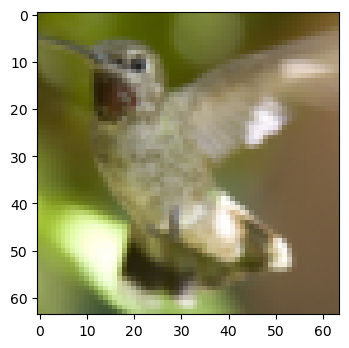

torch.Size([3, 64, 64])
<PIL.Image.Image image mode=RGB size=64x64 at 0x15523EDBB5B0>


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x15523ff40820>


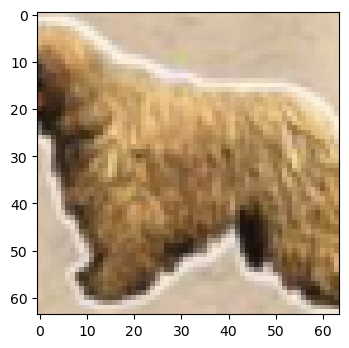

Traceback (most recent call last):
  File "/ext3/miniconda3/envs/dev/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/ext3/miniconda3/envs/dev/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/ext3/miniconda3/envs/dev/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


torch.Size([3, 64, 64])
<PIL.Image.Image image mode=RGB size=64x64 at 0x15523EC50F10>


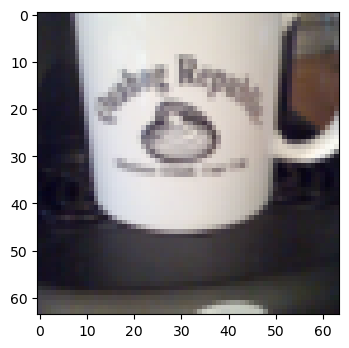

torch.Size([3, 64, 64])
<PIL.Image.Image image mode=RGB size=64x64 at 0x15523F37D220>


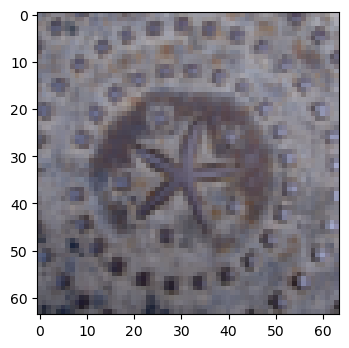

torch.Size([3, 64, 64])
<PIL.Image.Image image mode=RGB size=64x64 at 0x15523F2860D0>


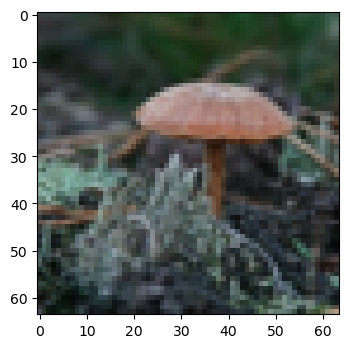

torch.Size([3, 64, 64])
<PIL.Image.Image image mode=RGB size=64x64 at 0x15523F2D5580>


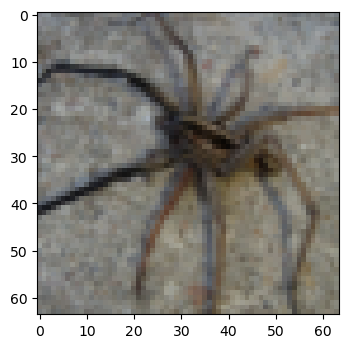

torch.Size([3, 64, 64])
<PIL.Image.Image image mode=RGB size=64x64 at 0x15523E95F730>


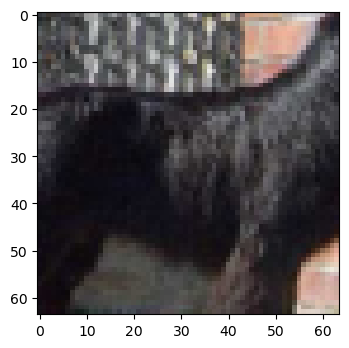

torch.Size([3, 64, 64])
<PIL.Image.Image image mode=RGB size=64x64 at 0x15522A6BC580>


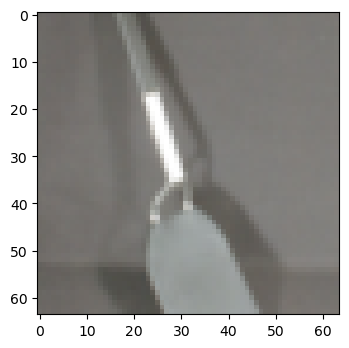

torch.Size([3, 64, 64])
<PIL.Image.Image image mode=RGB size=64x64 at 0x15523EA082E0>


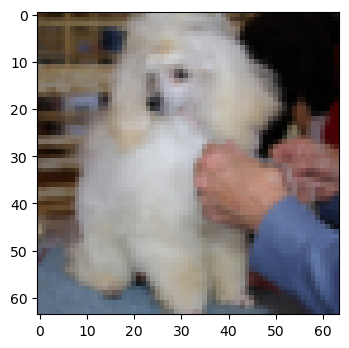

torch.Size([3, 64, 64])
<PIL.Image.Image image mode=RGB size=64x64 at 0x15523ED2A3D0>


In [64]:
from PIL import Image
trans = transforms.ToPILImage()
from torchvision import transforms, utils
i = 0
with torch.no_grad():
    for t_img, y in evalloader:
        plt.imshow(t_img[0].permute(1, 2, 0))
        plt.show()
        t_img = t_img.cuda()
        result, mu, logvar = vae.forward(t_img)
        result = result.cpu()
        print(result.data[0].shape)
#         plt.imshow(  result.permute(1, 2, 0)  )
        print(trans(result.data[0]))
#         show_normalized_image(trans(result.data[0]).cpu())
        utils.save_image(result.data, str(i) + '.png', normalize=True)
        i += 1
        if i == 10: break

In [65]:
net.train()
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

#         break

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
#     break

print('Finished Training')

Start Training
[1,    10] loss: 0.205
[1,    20] loss: 0.274
[1,    30] loss: 0.251
[1,    40] loss: 0.228
[1,    50] loss: 0.236
[1,    60] loss: 0.244
[1,    70] loss: 0.251
[1,    80] loss: 0.229
[1,    90] loss: 0.289
[1,   100] loss: 0.267
[1,   110] loss: 0.301
[1,   120] loss: 0.187
[1,   130] loss: 0.264
[1,   140] loss: 0.242
[1,   150] loss: 0.236
[1,   160] loss: 0.248
[1,   170] loss: 0.224
[1,   180] loss: 0.265
[1,   190] loss: 0.262
[1,   200] loss: 0.263
[1,   210] loss: 0.225
[1,   220] loss: 0.252
[1,   230] loss: 0.259
[1,   240] loss: 0.265
[1,   250] loss: 0.214
[1,   260] loss: 0.197
[1,   270] loss: 0.215
[1,   280] loss: 0.212
[1,   290] loss: 0.248
[1,   300] loss: 0.260
[1,   310] loss: 0.239
[1,   320] loss: 0.242
[1,   330] loss: 0.219
[1,   340] loss: 0.218
[1,   350] loss: 0.285
[1,   360] loss: 0.233
[1,   370] loss: 0.229
[1,   380] loss: 0.244
[1,   390] loss: 0.268
[1,   400] loss: 0.259
[1,   410] loss: 0.269
[1,   420] loss: 0.255
[1,   430] loss: 0.

In [ ]:
save_model_location = '/scratch/vvb238/models/'
os.makedirs(save_model_location, exist_ok=True)
torch.save(vae.state_dict(), os.path.join(save_model_location, "vaeresnet18.pth"))

In [67]:
evalset = CustomDataset(root='/dataset', split="val", transform=eval_transform)
evalloader = torch.utils.data.DataLoader(evalset, batch_size=256, shuffle=False, num_workers=2)

net = model.cuda()

net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in evalloader:
        images, labels = data

        images = images.cuda()
        labels = labels.cuda()

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


print(f"Team {team_id}: {team_name} Accuracy: {(100 * correct / total):.2f}%")

Team 15: loSSLess Accuracy: 6.36%


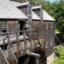

In [70]:
trans = transforms.ToPILImage()
transforms.Resize((64,64))(trans(unlabeledSet[1][0]))

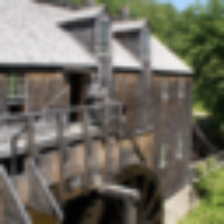

In [71]:
trans = transforms.ToPILImage()
transforms.Resize((224,224))(trans(unlabeledSet[1][0]))

In [87]:
x = ResNet18Enc()
x

ResNet18Enc(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlockEnc(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlockEnc(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 